In [1]:
# !pip install pyspark

In [ ]:
from pyspark.sql.functions import countDistinct, col
from pyspark.sql.functions import lit
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring
from pyspark.sql.functions import year, avg
from pyspark.sql.functions import log1p





In [1]:
# adjust computational resource allocation 


spark = SparkSession.builder \
    .appName("My PySpark App") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

In [2]:
# spark.stop()

In [2]:
folder_list = ["top", "popular", "esoteric", "diverse"]
entries_to_take = 1000 # the number of entries to take based on requirements and computational resources

subset_df = None

# loop through the folders and years to create a combined subset
for folder in folder_list:
    for year in range(2000, 2024):
        file_path = os.path.join(folder, f"{year}.json")
        if os.path.exists(file_path):
            temp_df = spark.read.json(file_path)
            
            # add the 'chart_type' column
            temp_df = temp_df.withColumn('chart_type', lit(folder))
            
            # limit the DataFrame to the top 'entries_to_take' rows
            temp_df = temp_df.limit(entries_to_take)
            
            # union the DataFrames
            if subset_df is None:
                subset_df = temp_df
            else:
                subset_df = subset_df.union(temp_df)

In [3]:
subset_df.count()

96000

In [4]:
subset_df.printSchema()

root
 |-- Album: string (nullable = true)
 |-- Artist Name: string (nullable = true)
 |-- Average Rating: string (nullable = true)
 |-- Descriptors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Ranking: long (nullable = true)
 |-- Release Date: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- spotify album uri: string (nullable = true)
 |-- spotify artist followers: long (nullable = true)
 |-- spotify artist genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- spotify artist name: string (nullable = true)
 |-- spotify artist popularity: long (nullable = true)
 |-- spotify artist uri: string (nullable = true)
 |-- spotify disc number: long (nullable = true)
 |-- spotify track duration: long (nullable = true)
 |-- spotify track features: struct (nullable = true)
 |    |-- acousticness: double (nullable = true)
 |    |-- danceability: double (nullable = true)
 |    |-- energy: double (nullable = true)
 |    |-- inst

In [5]:
df = subset_df

In [6]:
# drop the specified columns
df = df.drop('spotify track number', 'spotify album uri', 'spotify artist uri', 'spotify track uri', 'spotify disc number')

In [7]:
# check data types, unique values, and summary statistics, and check for missing values
print("Data types:\n", df.dtypes)


Data types:
 [('Album', 'string'), ('Artist Name', 'string'), ('Average Rating', 'string'), ('Descriptors', 'string'), ('Genres', 'string'), ('Ranking', 'bigint'), ('Release Date', 'string'), ('lyrics', 'string'), ('spotify artist followers', 'bigint'), ('spotify artist genres', 'array<string>'), ('spotify artist name', 'string'), ('spotify artist popularity', 'bigint'), ('spotify track duration', 'bigint'), ('spotify track features', 'struct<acousticness:double,danceability:double,energy:double,instrumentalness:double,liveness:double,loudness:double,speechiness:double,tempo:double,valence:double>'), ('spotify track name', 'string'), ('spotify track popularity', 'bigint'), ('chart_type', 'string')]


In [8]:
# counting distinct values



print("\nNumber of unique values:\n")
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()



Number of unique values:

+-----+-----------+--------------+-----------+------+-------+------------+------+------------------------+---------------------+-------------------+-------------------------+----------------------+----------------------+------------------+------------------------+----------+
|Album|Artist Name|Average Rating|Descriptors|Genres|Ranking|Release Date|lyrics|spotify artist followers|spotify artist genres|spotify artist name|spotify artist popularity|spotify track duration|spotify track features|spotify track name|spotify track popularity|chart_type|
+-----+-----------+--------------+-----------+------+-------+------------+------+------------------------+---------------------+-------------------+-------------------------+----------------------+----------------------+------------------+------------------------+----------+
| 4793|       3132|           225|       4390|  2393|    164|        2539| 42646|                    4986|                 2445|               30

In [9]:
print("\nSummary statistics:\n")
df.describe().show()


Summary statistics:

+-------+------------------+-----------+------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------------+-------------------+-------------------------+----------------------+------------------+------------------------+----------+
|summary|             Album|Artist Name|    Average Rating|         Descriptors|              Genres|           Ranking|      Release Date|              lyrics|spotify artist followers|spotify artist name|spotify artist popularity|spotify track duration|spotify track name|spotify track popularity|chart_type|
+-------+------------------+-----------+------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------------+-------------------+-------------------------+----------------------+------------------+------------------------+----------+
|  count|             96000|      96000|        

In [11]:
# drop missing values for specified columns
df = df.na.drop(subset=['Genres', 'spotify artist name', 'spotify artist popularity', 'spotify artist followers', 'spotify artist genres'])

In [13]:
# drop duplicates
subset_cols = ['Album', 'Artist Name', 'spotify track name']
df = df.dropDuplicates(subset_cols)

In [15]:
# cnvert 'Average Rating' column to numeric
df = df.withColumn('Average Rating', col('Average Rating').cast(FloatType()))

In [17]:
df.dtypes

[('Album', 'string'),
 ('Artist Name', 'string'),
 ('Average Rating', 'float'),
 ('Descriptors', 'string'),
 ('Genres', 'string'),
 ('Ranking', 'bigint'),
 ('Release Date', 'string'),
 ('lyrics', 'string'),
 ('spotify artist followers', 'bigint'),
 ('spotify artist genres', 'array<string>'),
 ('spotify artist name', 'string'),
 ('spotify artist popularity', 'bigint'),
 ('spotify track duration', 'bigint'),
 ('spotify track features',
  'struct<acousticness:double,danceability:double,energy:double,instrumentalness:double,liveness:double,loudness:double,speechiness:double,tempo:double,valence:double>'),
 ('spotify track name', 'string'),
 ('spotify track popularity', 'bigint'),
 ('chart_type', 'string')]

In [22]:
# list of the feature names
feature_names = ["acousticness", "danceability", "energy", "instrumentalness", 
                 "liveness", "loudness", "speechiness", "tempo", "valence"]

#  create a new DataFrame with the nested columns flattened
df = df.select("*", *(col("spotify track features." + feature) for feature in feature_names))

# drop the original 'spotify track features' column
df = df.drop("spotify track features")


In [23]:
df.printSchema()

root
 |-- Album: string (nullable = true)
 |-- Artist Name: string (nullable = true)
 |-- Average Rating: float (nullable = true)
 |-- Descriptors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Ranking: long (nullable = true)
 |-- Release Date: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- spotify artist followers: long (nullable = true)
 |-- spotify artist genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- spotify artist name: string (nullable = true)
 |-- spotify artist popularity: long (nullable = true)
 |-- spotify track duration: long (nullable = true)
 |-- spotify track name: string (nullable = true)
 |-- spotify track popularity: long (nullable = true)
 |-- chart_type: string (nullable = false)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = tru

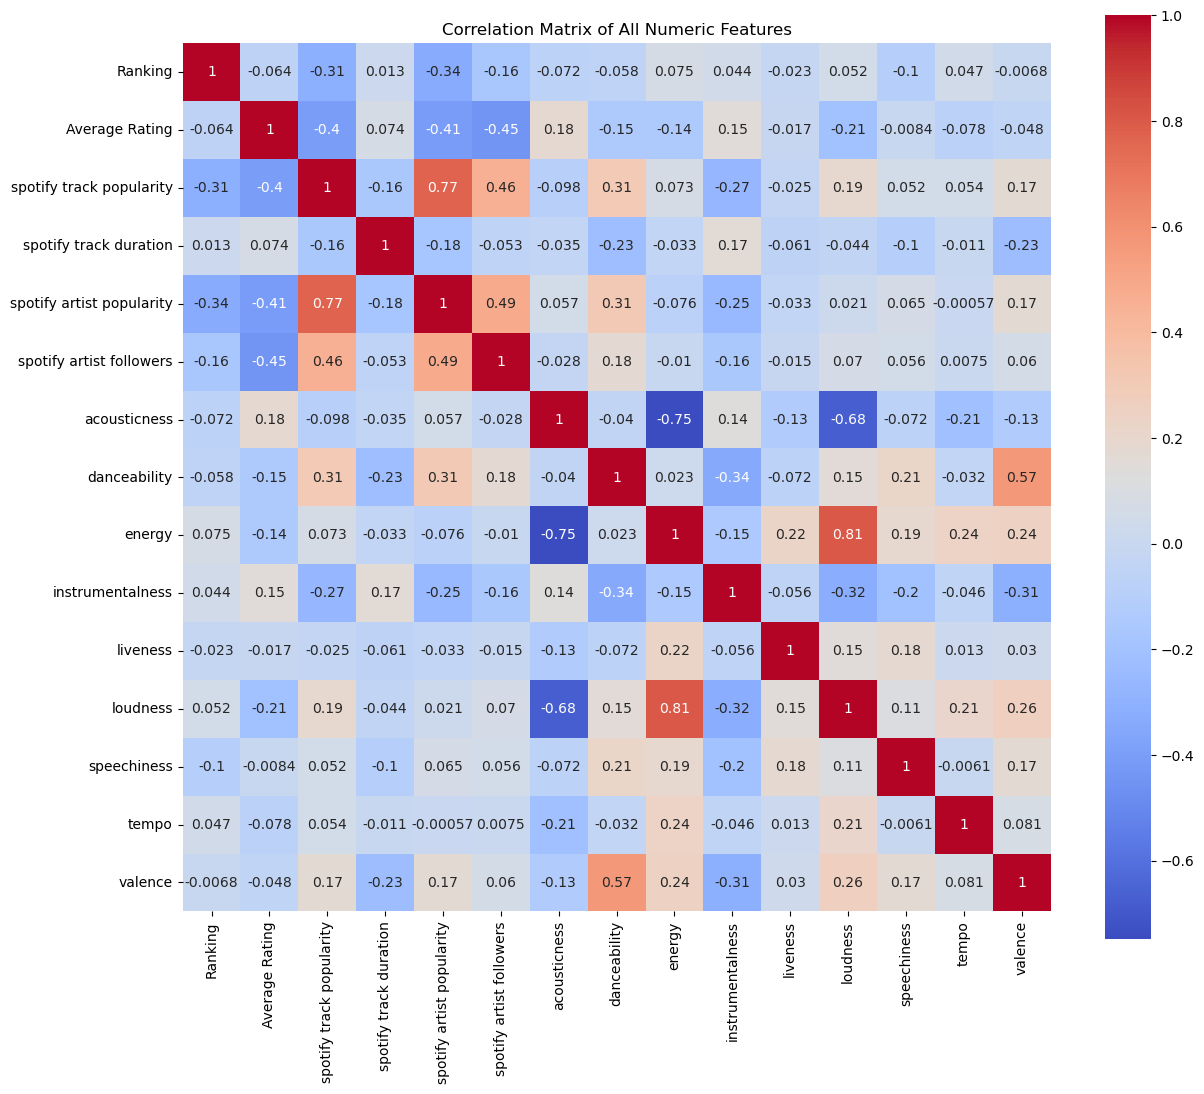

In [24]:
columns = ['Ranking', 'Average Rating', 'spotify track popularity', 'spotify track duration', 'spotify artist popularity', 'spotify artist followers', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# create a vectorassembler 
vectorAssembler = VectorAssembler(inputCols=columns, outputCol="features")
df_vector = vectorAssembler.transform(df).select('features')

# compute the correlation matrix
matrix = Correlation.corr(df_vector, "features")

# fetch the correlation matrix and convert it to pandas dataframe for visualization
corr_matrix = matrix.collect()[0]["pearson({})".format("features")].toArray()
corr_df = pd.DataFrame(corr_matrix, columns=columns, index=columns)

# plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of All Numeric Features")
plt.show()


In [25]:

# creating a 'Year' column from Release Date

df = df.withColumn('Year', substring(df['Release Date'], -4, 4).cast("int"))


In [27]:
# df.columns

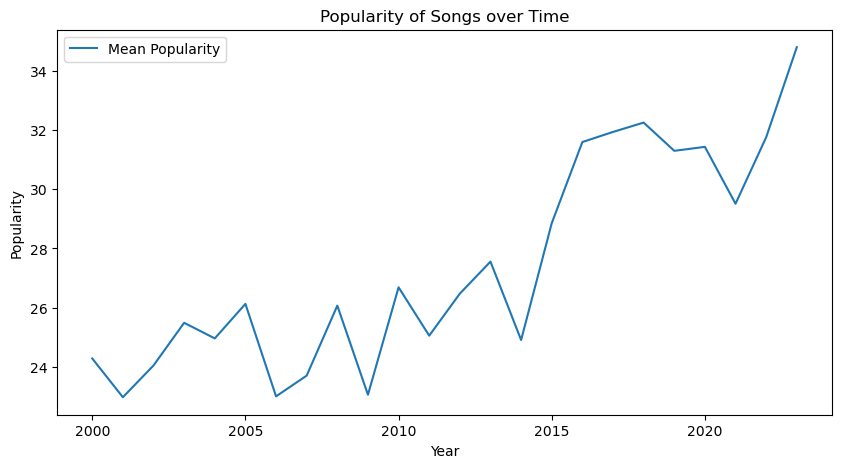

In [30]:


# group by 'Year' and calculate the mean popularity
popularity = df.groupBy('Year').agg(avg('spotify track popularity').alias('Mean Popularity')).orderBy('Year')

# convert the result to Pandas for plotting
popularity_pd = popularity.toPandas()

# set 'Year' as index
popularity_pd.set_index('Year', inplace=True)

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(popularity_pd.index, popularity_pd['Mean Popularity'], label='Mean Popularity')
ax.set_xlabel('Year')
ax.set_ylabel('Popularity')
ax.set_title('Popularity of Songs over Time')
ax.legend(loc='best')

plt.show()


In [31]:
# df.show()

In [32]:

# track duration to seconds
df = df.withColumn('spotify track duration', df['spotify track duration'] / 1000)

# do log transformation to the followers count
df = df.withColumn('log_spotify_artist_followers', log1p(df['spotify artist followers']))


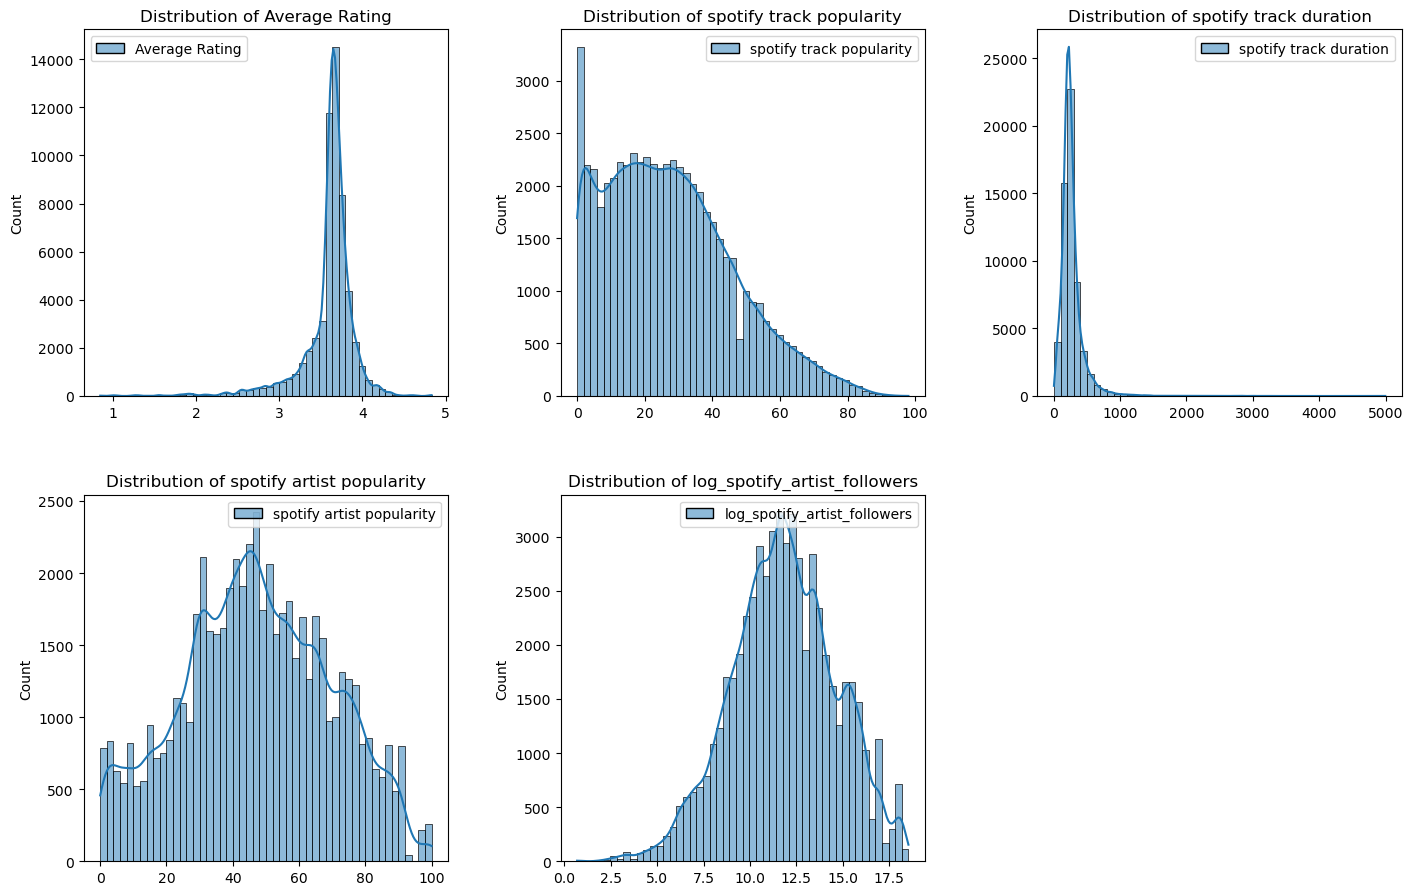

In [36]:
columns_to_plot = ['Average Rating', 'spotify track popularity', 'spotify track duration', 'spotify artist popularity', 'log_spotify_artist_followers']
colors = ['#1DB954', '#FF2D55', '#FF9500', '#4CD964', '#5AC8FA', '#007AFF', '#5856D6', '#FF3B30', '#FFCC00']

#  subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# distribution plots
for index, col in enumerate(columns_to_plot):
    row, col_index = divmod(index, 3)
    
    # convert the column to Pandas for plotting
    pandas_col = df.select(col).toPandas()
    
    sns.histplot(pandas_col, bins=50, ax=axes[row, col_index], color=colors[index % len(colors)], kde=True)
    axes[row, col_index].set_title(f'Distribution of {col}')

# remove the last unused subplot
fig.delaxes(axes[1, 2])

plt.show()


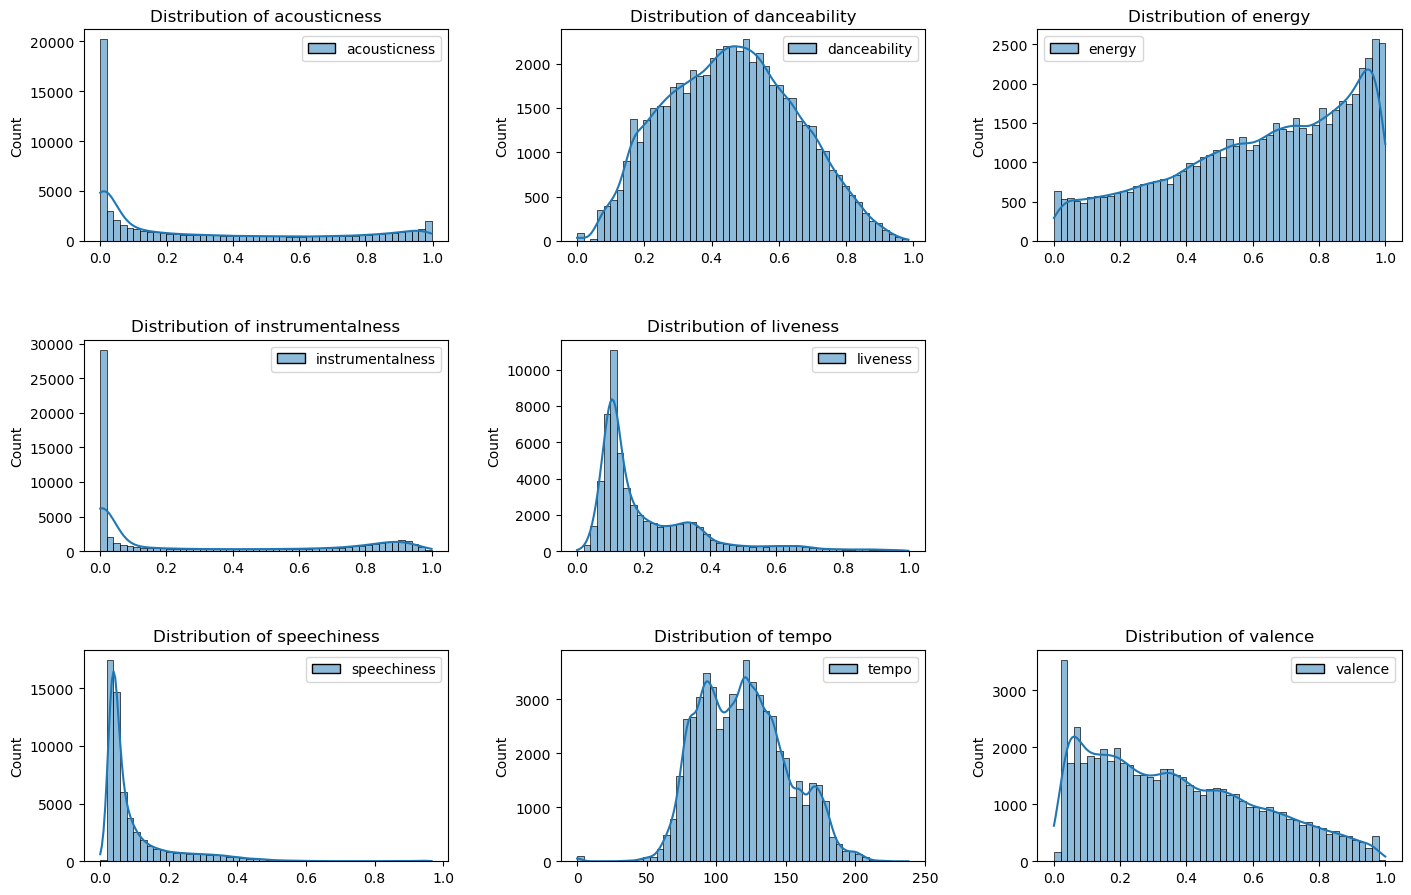

In [37]:
columns_to_plot = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
colors = ['#1DB954', '#FF2D55', '#FF9500', '#4CD964', '#5AC8FA', '#007AFF', '#5856D6', '#FF3B30', '#FFCC00']

#  subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# the distribution plots
for index, col in enumerate(columns_to_plot):
    row, col_index = divmod(index, 3)
    
    # convert the column to Pandas for plotting
    pandas_col = df.select(col).toPandas()
    
    sns.histplot(pandas_col, bins=50, ax=axes[row, col_index], color=colors[index % len(colors)], kde=True)
    axes[row, col_index].set_title(f'Distribution of {col}')

# remove the last unused subplot
fig.delaxes(axes[1, 2])

plt.show()


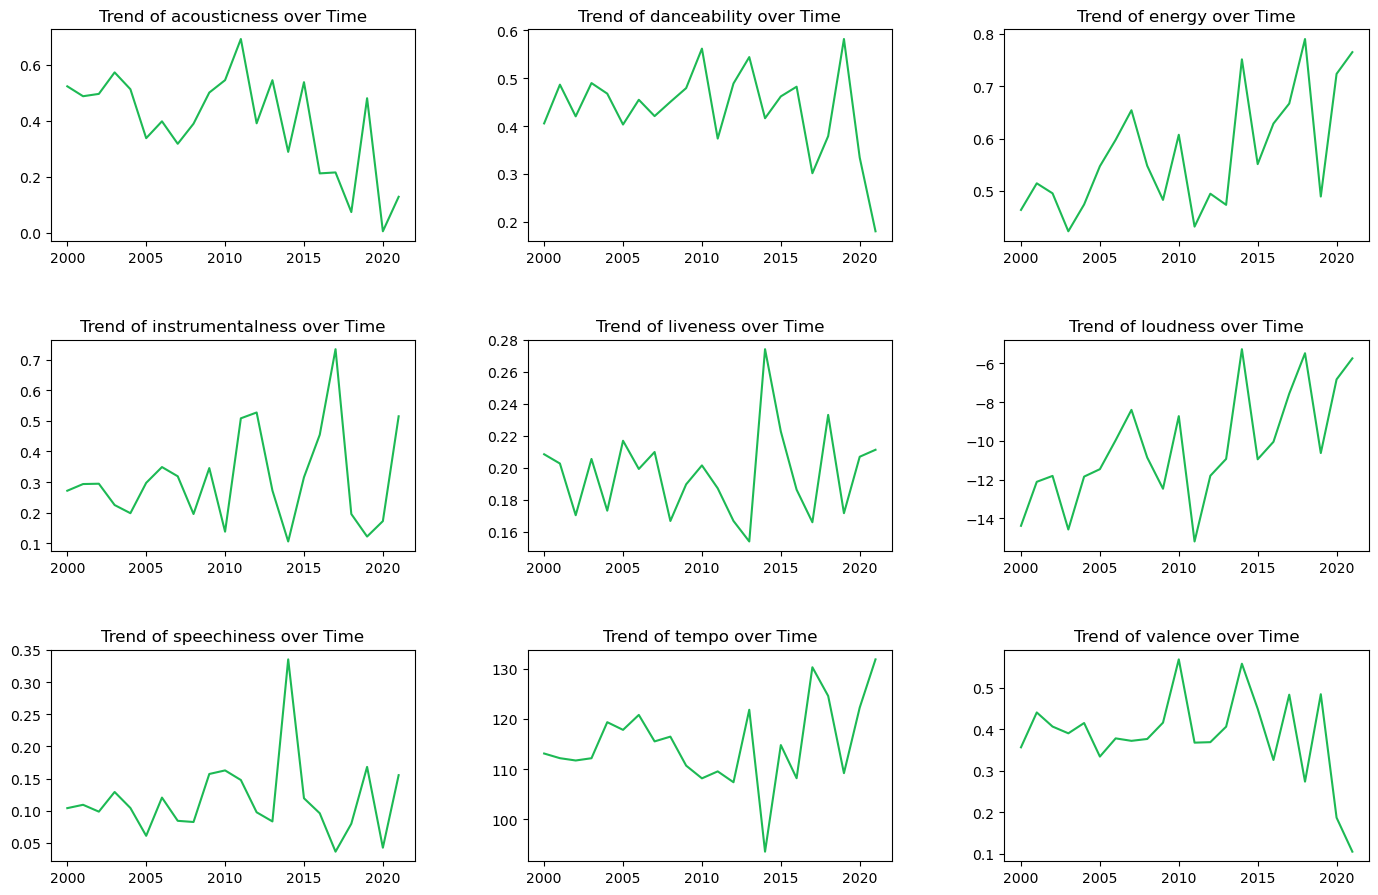

In [40]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

#  subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# get the year from the 'Release Date' column
df = df.withColumn('Year', year(df['Release Date']))

for index, feature in enumerate(features):
    row, col_index = divmod(index, 3)

    # calculate the yearly average 
    feature_avg = df.groupBy('Year').agg({feature: 'mean'}).orderBy('Year')
    
    # convert to Pandas for plotting
    feature_avg = feature_avg.toPandas()
    
    # plot 
    axes[row, col_index].plot(feature_avg['Year'], feature_avg[f'avg({feature})'])
    axes[row, col_index].set_title(f'Trend of {feature} over Time')

plt.show()


### Trying same plots using pandas dataframe

In [41]:
pandas_df = df.toPandas()

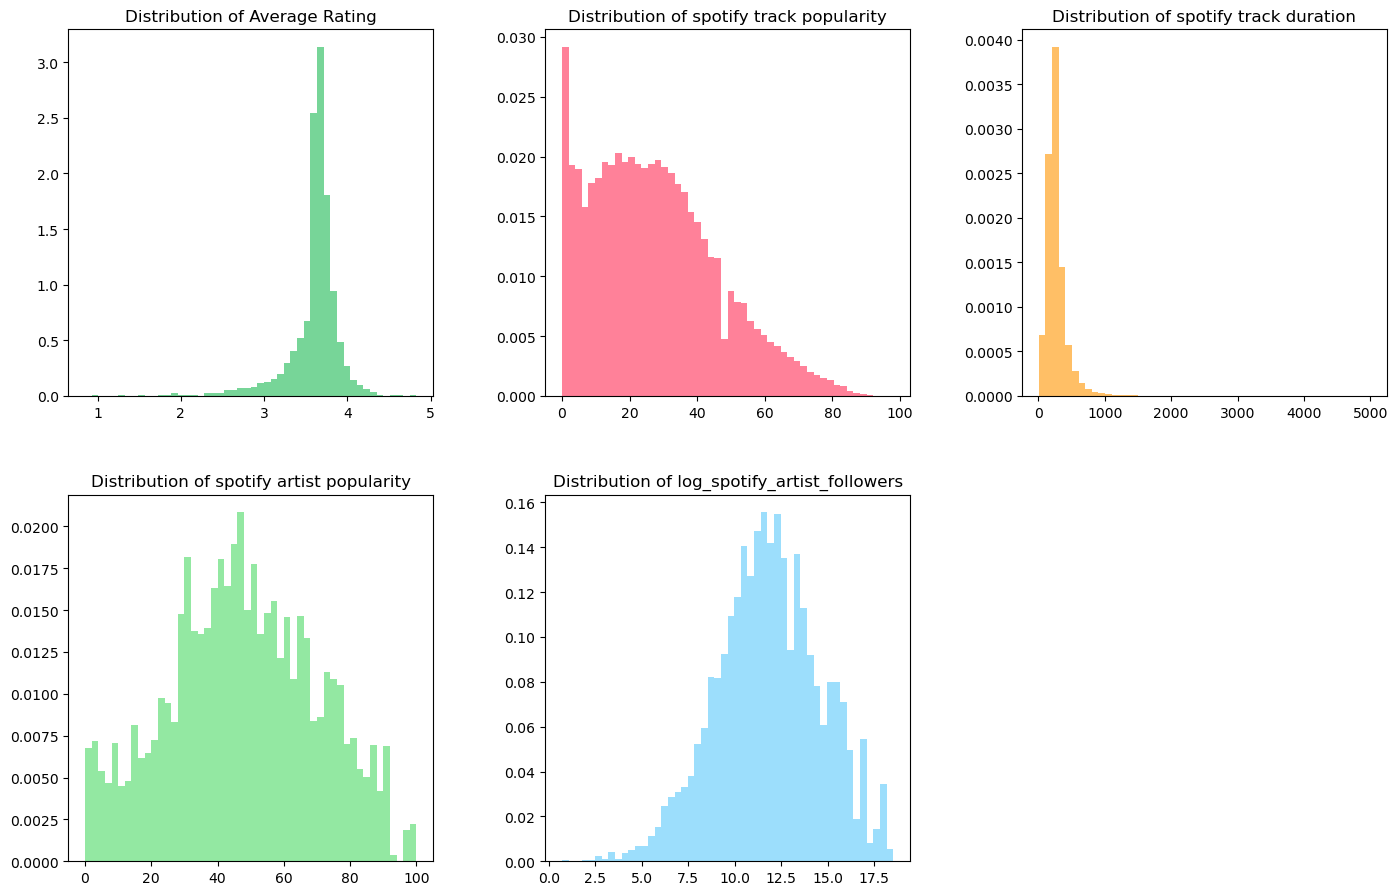

In [43]:
columns_to_plot = ['Average Rating', 'spotify track popularity', 'spotify track duration', 'spotify artist popularity', 'log_spotify_artist_followers']

colors = ['#1DB954', '#FF2D55', '#FF9500', '#4CD964', '#5AC8FA', '#007AFF', '#5856D6', '#FF3B30', '#FFCC00']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)


for index, col in enumerate(columns_to_plot):
    row, col_index = divmod(index, 3)
    axes[row, col_index].hist(pandas_df[col], bins=50, density=True, alpha=0.6, color=colors[index])
    axes[row, col_index].set_title(f'Distribution of {col}')


fig.delaxes(axes[1, 2])

plt.show()


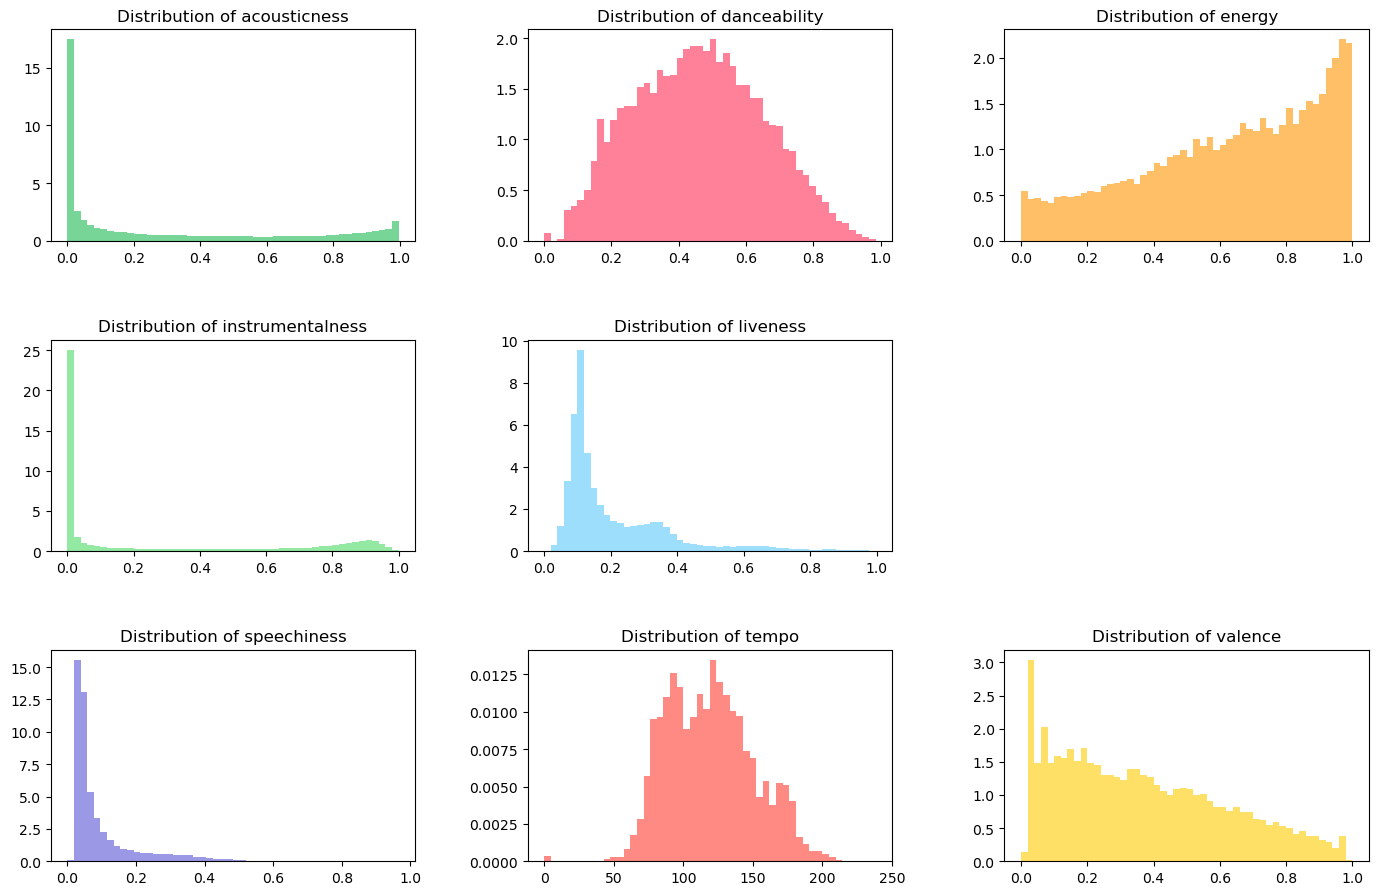

In [44]:
columns_to_plot = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

colors = ['#1DB954', '#FF2D55', '#FF9500', '#4CD964', '#5AC8FA', '#007AFF', '#5856D6', '#FF3B30', '#FFCC00']


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=5.0)


for index, col in enumerate(columns_to_plot):
    row, col_index = divmod(index, 3)
    axes[row, col_index].hist(pandas_df[col], bins=50, density=True, alpha=0.6, color=colors[index])
    axes[row, col_index].set_title(f'Distribution of {col}')


fig.delaxes(axes[1, 2])

plt.show()

In [47]:
track_features_df = pandas_df

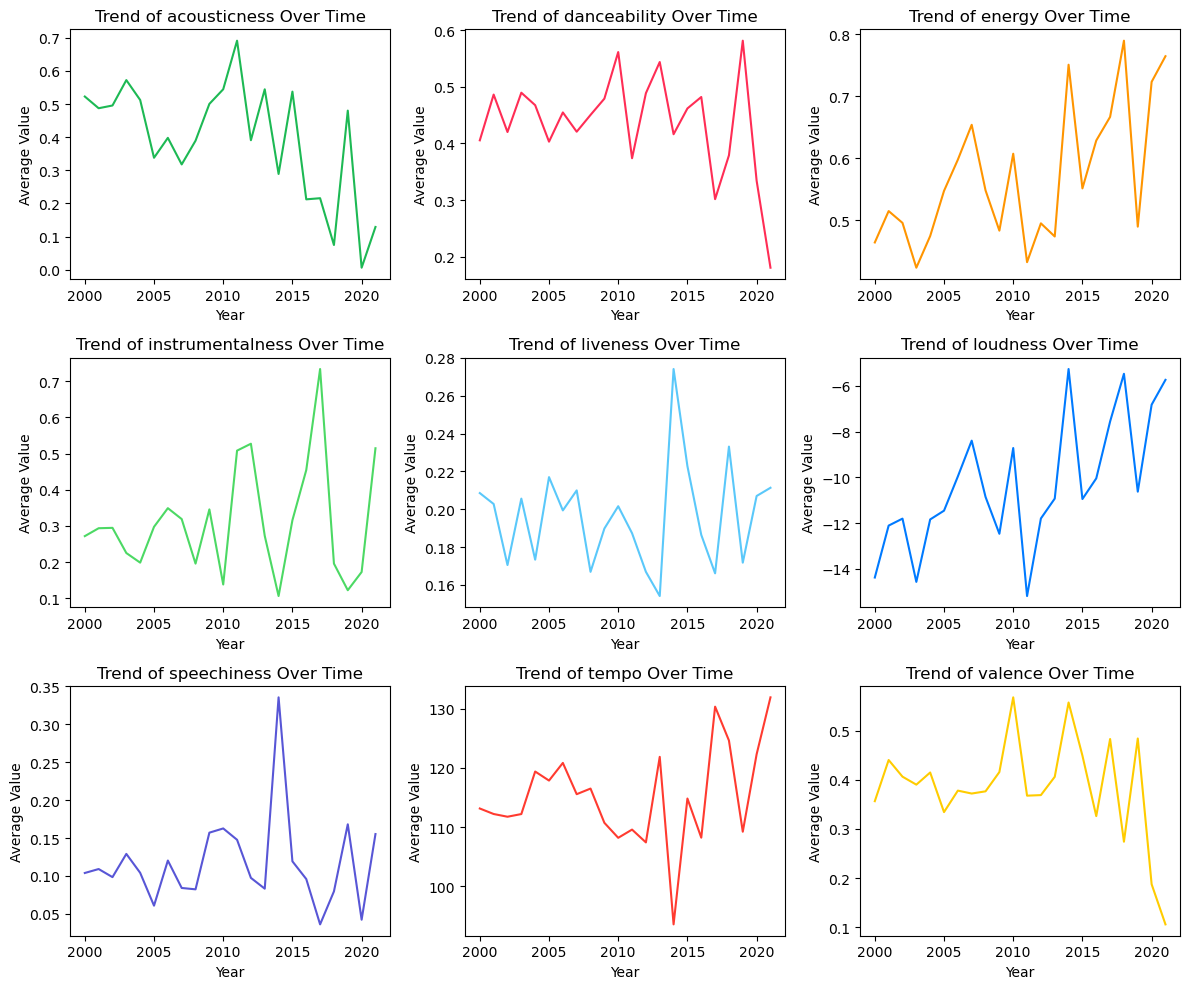

In [48]:
track_features_df.set_index('Year', inplace=True)

feature_list = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))


for i, feature in enumerate(feature_list):
    row = i // 3
    col = i % 3
    feature_by_year = track_features_df.groupby('Year')[feature].mean()
    axes[row, col].plot(feature_by_year.index, feature_by_year.values, color = colors[i])
    axes[row, col].set_title(f'Trend of {feature} Over Time')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Average Value')

plt.tight_layout()
plt.show()

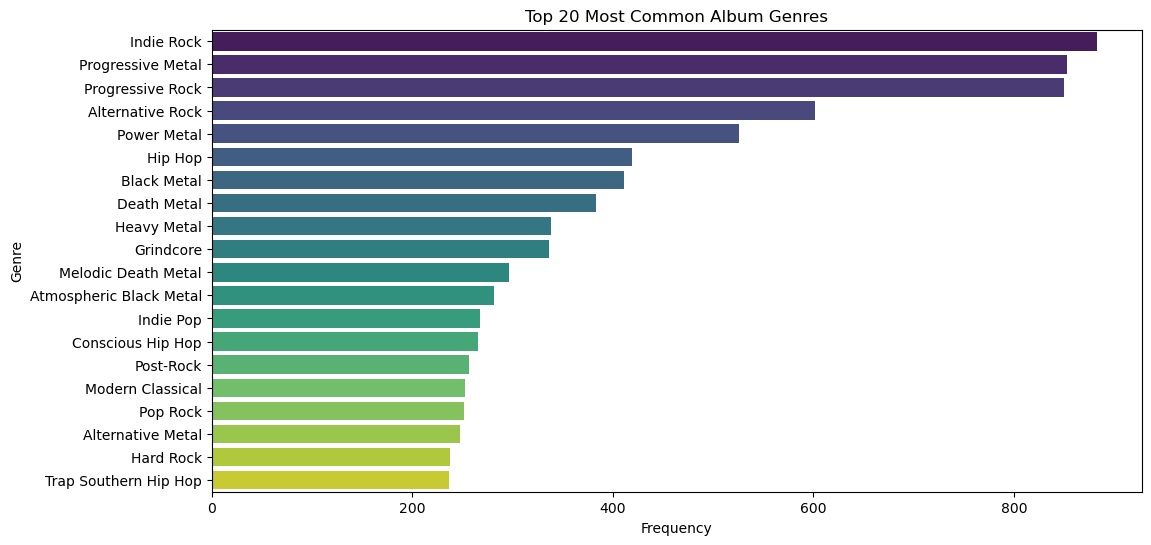

In [50]:
# Top 20 Most Common Album Genres

genre_counts = pandas_df.explode('Genres')['Genres'].value_counts().nlargest(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 20 Most Common Album Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

C:\Users\khali\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\khali\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\khali\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\khali\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\khali\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45376 (\N{HANGUL SYLLABLE NYEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


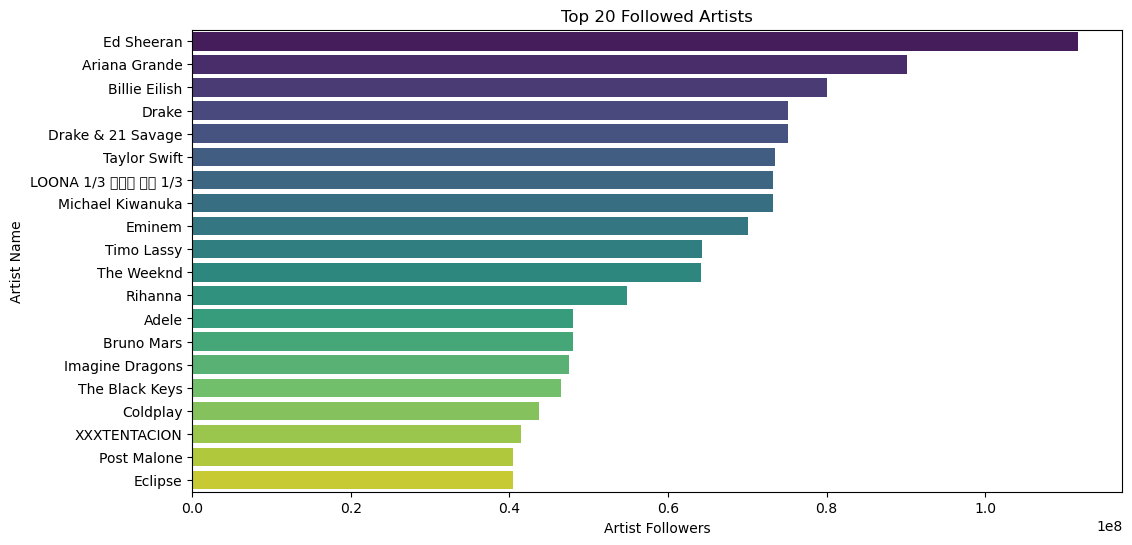

In [53]:
# Top 20 Followed Artists

artist_followers = pandas_df.groupby('Artist Name')['spotify artist followers'].max().reset_index()
top_followed_artists = artist_followers.nlargest(20, 'spotify artist followers')
plt.figure(figsize=(12, 6))
sns.barplot(x='spotify artist followers', y='Artist Name', data=top_followed_artists, palette='viridis')
plt.title('Top 20 Followed Artists')
plt.xlabel('Artist Followers')
plt.ylabel('Artist Name')
plt.show()